## Migration Number Prediction for HongKongers Post Social / Political Movement

In [1]:
!pip install xgboost
!pip install skforecast

In [2]:
!pip install pandas
import pandas as pd

### Data Collection

In [154]:
# Import data from csv files

NER_count_V = pd.read_csv('NER_count_filtered_Visualization.csv')
Airport_count_V = pd.read_csv('Airport_count_Visualization.csv')

In [4]:
# Print to look at data structure and format

NER_count_V.head()

,Unnamed: 0,comment_datetime,ner,size
0,0,2022-03-31,"('香港', 'S-GPE')",185
1,1,2022-03-16,"('香港', 'S-GPE')",153
2,4,2022-03-29,"('香港', 'S-GPE')",128
3,5,2022-04-11,"('香港', 'S-GPE')",125
4,6,2022-04-17,"('香港', 'S-GPE')",120


In [16]:
# Print to look at data structure and format

Airport_count_V.head()

,Date,Control Point,Arrival / Departure,Hong Kong Residents,Mainland Visitors,Other Visitors,Total
0,2021-01-01,Airport,Departure,803.0,17.0,28.0,848.0
369,2021-01-02,Airport,Departure,940.0,22.0,33.0,995.0
6614,2021-01-03,Airport,Departure,1146.0,31.0,44.0,1221.0
2421,2021-01-04,Airport,Departure,455.0,2.0,41.0,498.0
372,2021-01-05,Airport,Departure,1184.0,36.0,49.0,1269.0


## Data Processing
### To ensure that data structure and data format fit into XGBoost and SKForecaster requirements

In [6]:
# As observed, there is an addiitonal column not useful to our data structure, hence .drop

Airport_count_V = Airport_count_V.drop(columns=['Unnamed: 0',])
NER_count_V = NER_count_V.drop(columns=['Unnamed: 0'])

In [12]:
Airport_count_V = Airport_count_V.sort_values(['Date'])

In [14]:
# As observed, airport data downloaded from government website has got duplciation, hence .drop_duplicates

Airport_count_V = Airport_count_V.drop_duplicates(subset ="Date")

In [7]:
# Convert NER column into pivot table - moving horizontally instead of vertically

NER_count_V_columned = NER_count_V.pivot_table(values='size', index='comment_datetime', columns='ner', aggfunc='first')

In [8]:
# Fill NA column with 0 and NA will impact XGBoost & SKForecaster

NER_count_V_columned = NER_count_V_columned.fillna(0)
NER_count_V_columned = NER_count_V_columned.reset_index()

In [9]:
# Print to look at data structure and format

NER_count_V_columned.head(5)

ner,comment_datetime,"('东京', 'S-GPE')","('中国', 'S-GPE')","('伦敦', 'S-GPE')","('加拿大', 'S-GPE')","('台中', 'S-GPE')","('台北', 'S-GPE')","('台湾', 'S-GPE')","('多伦多', 'S-GPE')","('大阪', 'S-GPE')",...,"('日', 'S-GPE')","('日本', 'S-GPE')","('温哥华', 'S-GPE')","('港', 'S-GPE')","('澳洲', 'S-GPE')","('美国', 'S-GPE')","('英', 'S-GPE')","('英国', 'S-GPE')","('韩国', 'S-GPE')","('香港', 'S-GPE')"
0,2021-01-01,1.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,...,1.0,17.0,0.0,1.0,0.0,2.0,1.0,4.0,0.0,20.0
1,2021-01-02,1.0,1.0,4.0,1.0,0.0,0.0,6.0,0.0,0.0,...,0.0,6.0,0.0,1.0,1.0,9.0,2.0,22.0,0.0,24.0
2,2021-01-03,0.0,0.0,2.0,2.0,0.0,0.0,6.0,0.0,0.0,...,2.0,6.0,0.0,1.0,0.0,0.0,1.0,7.0,1.0,14.0
3,2021-01-04,2.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,2.0,6.0,0.0,1.0,0.0,4.0,3.0,8.0,1.0,12.0
4,2021-01-05,5.0,5.0,3.0,2.0,0.0,1.0,38.0,0.0,1.0,...,4.0,2.0,0.0,3.0,5.0,4.0,8.0,26.0,0.0,47.0


In [15]:
print(len(Airport_count_V), len(NER_count_V_columned))

525 521


In [11]:
len(pd.unique(Airport_count_V['Date']))

525

In [17]:
# Left join data with date

dataset_merged = pd.merge(Airport_count_V, NER_count_V_columned, how='left', left_on='Date',right_on='comment_datetime')

In [18]:
# Print to look at data structure and format

dataset_merged.head()

,Date,Control Point,Arrival / Departure,Hong Kong Residents,Mainland Visitors,Other Visitors,Total,comment_datetime,"('东京', 'S-GPE')","('中国', 'S-GPE')",...,"('日', 'S-GPE')","('日本', 'S-GPE')","('温哥华', 'S-GPE')","('港', 'S-GPE')","('澳洲', 'S-GPE')","('美国', 'S-GPE')","('英', 'S-GPE')","('英国', 'S-GPE')","('韩国', 'S-GPE')","('香港', 'S-GPE')"
0,2021-01-01,Airport,Departure,803.0,17.0,28.0,848.0,2021-01-01,1.0,0.0,...,1.0,17.0,0.0,1.0,0.0,2.0,1.0,4.0,0.0,20.0
1,2021-01-02,Airport,Departure,940.0,22.0,33.0,995.0,2021-01-02,1.0,1.0,...,0.0,6.0,0.0,1.0,1.0,9.0,2.0,22.0,0.0,24.0
2,2021-01-03,Airport,Departure,1146.0,31.0,44.0,1221.0,2021-01-03,0.0,0.0,...,2.0,6.0,0.0,1.0,0.0,0.0,1.0,7.0,1.0,14.0
3,2021-01-04,Airport,Departure,455.0,2.0,41.0,498.0,2021-01-04,2.0,4.0,...,2.0,6.0,0.0,1.0,0.0,4.0,3.0,8.0,1.0,12.0
4,2021-01-05,Airport,Departure,1184.0,36.0,49.0,1269.0,2021-01-05,5.0,5.0,...,4.0,2.0,0.0,3.0,5.0,4.0,8.0,26.0,0.0,47.0


In [19]:
# Converting date to datetime in order to split date into year, month, day

dataset_merged['comment_datetime'] = pd.to_datetime(dataset_merged['comment_datetime']) 

In [20]:
dataset_merged['year'] = dataset_merged['comment_datetime'].apply(lambda x: x.year)
dataset_merged['month'] = dataset_merged['comment_datetime'].apply(lambda x: x.month)
dataset_merged['day'] = dataset_merged['comment_datetime'].apply(lambda x: x.day)

In [21]:
# Print to look at data structure and format

dataset_merged.head()

,Date,Control Point,Arrival / Departure,Hong Kong Residents,Mainland Visitors,Other Visitors,Total,comment_datetime,"('东京', 'S-GPE')","('中国', 'S-GPE')",...,"('港', 'S-GPE')","('澳洲', 'S-GPE')","('美国', 'S-GPE')","('英', 'S-GPE')","('英国', 'S-GPE')","('韩国', 'S-GPE')","('香港', 'S-GPE')",year,month,day
0,2021-01-01,Airport,Departure,803.0,17.0,28.0,848.0,2021-01-01,1.0,0.0,...,1.0,0.0,2.0,1.0,4.0,0.0,20.0,2021.0,1.0,1.0
1,2021-01-02,Airport,Departure,940.0,22.0,33.0,995.0,2021-01-02,1.0,1.0,...,1.0,1.0,9.0,2.0,22.0,0.0,24.0,2021.0,1.0,2.0
2,2021-01-03,Airport,Departure,1146.0,31.0,44.0,1221.0,2021-01-03,0.0,0.0,...,1.0,0.0,0.0,1.0,7.0,1.0,14.0,2021.0,1.0,3.0
3,2021-01-04,Airport,Departure,455.0,2.0,41.0,498.0,2021-01-04,2.0,4.0,...,1.0,0.0,4.0,3.0,8.0,1.0,12.0,2021.0,1.0,4.0
4,2021-01-05,Airport,Departure,1184.0,36.0,49.0,1269.0,2021-01-05,5.0,5.0,...,3.0,5.0,4.0,8.0,26.0,0.0,47.0,2021.0,1.0,5.0


In [66]:
dataset_merged['Date'].min()

'2021-01-01'

In [67]:
dataset_merged['Date'].max()

'2022-06-09'

In [68]:
dataset_merged['comment_datetime'].min()

Timestamp('2021-01-01 00:00:00')

In [69]:
dataset_merged['comment_datetime'].max()

Timestamp('2022-06-09 00:00:00')

In [70]:
len(dataset_merged)

521

### Prepare data according to model training and model testing needs  

In [71]:
needed_col = ['Hong Kong Residents','comment_datetime',
       "('东京', 'S-GPE')", "('中国', 'S-GPE')", "('伦敦', 'S-GPE')",
       "('加拿大', 'S-GPE')", "('台中', 'S-GPE')", "('台北', 'S-GPE')",
       "('台湾', 'S-GPE')", "('多伦多', 'S-GPE')", "('大阪', 'S-GPE')",
       "('大陆', 'S-GPE')", "('广东', 'S-GPE')", "('日', 'S-GPE')",
       "('日本', 'S-GPE')", "('温哥华', 'S-GPE')", "('港', 'S-GPE')",
       "('澳洲', 'S-GPE')", "('美国', 'S-GPE')", "('英', 'S-GPE')",
       "('英国', 'S-GPE')", "('韩国', 'S-GPE')", "('香港', 'S-GPE')", 'year',
       'month', 'day']

In [72]:
# Copy one set of clean dataset with the required columns only

dataset_to_train = dataset_merged[needed_col]

In [73]:
# Set datatime as index for the new dataset

dataset_to_train = dataset_to_train.set_index(dataset_to_train['comment_datetime'])

In [74]:
# Classify dataset date frequency as Daily

dataset_to_train = dataset_to_train.asfreq('D')

In [75]:
# Sort dataset by index before filtering

dataset_to_train = dataset_to_train.sort_index()

In [78]:
dataset_to_train = dataset_to_train.fillna(0)

In [79]:
# Print to look at new data structure and format

dataset_to_train.head()

,Hong Kong Residents,comment_datetime,"('东京', 'S-GPE')","('中国', 'S-GPE')","('伦敦', 'S-GPE')","('加拿大', 'S-GPE')","('台中', 'S-GPE')","('台北', 'S-GPE')","('台湾', 'S-GPE')","('多伦多', 'S-GPE')",...,"('港', 'S-GPE')","('澳洲', 'S-GPE')","('美国', 'S-GPE')","('英', 'S-GPE')","('英国', 'S-GPE')","('韩国', 'S-GPE')","('香港', 'S-GPE')",year,month,day
comment_datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01,803.0,2021-01-01 00:00:00,1.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,...,1.0,0.0,2.0,1.0,4.0,0.0,20.0,2021.0,1.0,1.0
2021-01-02,940.0,2021-01-02 00:00:00,1.0,1.0,4.0,1.0,0.0,0.0,6.0,0.0,...,1.0,1.0,9.0,2.0,22.0,0.0,24.0,2021.0,1.0,2.0
2021-01-03,1146.0,2021-01-03 00:00:00,0.0,0.0,2.0,2.0,0.0,0.0,6.0,0.0,...,1.0,0.0,0.0,1.0,7.0,1.0,14.0,2021.0,1.0,3.0
2021-01-04,455.0,2021-01-04 00:00:00,2.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,...,1.0,0.0,4.0,3.0,8.0,1.0,12.0,2021.0,1.0,4.0
2021-01-05,1184.0,2021-01-05 00:00:00,5.0,5.0,3.0,2.0,0.0,1.0,38.0,0.0,...,3.0,5.0,4.0,8.0,26.0,0.0,47.0,2021.0,1.0,5.0


In [80]:
len(dataset_to_train)

525

In [81]:
# Define new list for columns required as X for training

x_col = [
       "('东京', 'S-GPE')", "('中国', 'S-GPE')", "('伦敦', 'S-GPE')",
       "('加拿大', 'S-GPE')", "('台中', 'S-GPE')", "('台北', 'S-GPE')",
       "('台湾', 'S-GPE')", "('多伦多', 'S-GPE')", "('大阪', 'S-GPE')",
       "('大陆', 'S-GPE')", "('广东', 'S-GPE')", "('日', 'S-GPE')",
       "('日本', 'S-GPE')", "('温哥华', 'S-GPE')", "('港', 'S-GPE')",
       "('澳洲', 'S-GPE')", "('美国', 'S-GPE')", "('英', 'S-GPE')",
       "('英国', 'S-GPE')", "('韩国', 'S-GPE')", "('香港', 'S-GPE')", 'year',
       'month', 'day']

In [82]:
# Seperate top 70% of data for training purpose

dataset_train_set = dataset_to_train[:int(len(dataset_to_train)*0.7)]

In [83]:
# Seperate the remaining 30% of data for testing purpose

dataset_test_set = dataset_to_train[int(len(dataset_to_train)*0.7):]

In [84]:
len(dataset_train_set)

367

In [85]:
len(dataset_test_set)

158

In [86]:
X_train = dataset_train_set[x_col]
X_test = dataset_test_set[x_col]

## XGBoost

In [87]:
import xgboost as xgb

y_train = dataset_train_set['Hong Kong Residents']
y_test = dataset_test_set['Hong Kong Residents']

# Read in data

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# Specify parameters via map

param = {'max_depth':20, 'eta':0.3, 'objective':'reg:squarederror' }
num_round = 12
bst = xgb.train(param, dtrain, num_round)

# Make prediction

preds = bst.predict(dtest)

In [88]:
# Calculate R squared score with test dataset and prediction

from sklearn.metrics import r2_score
r2_score(y_test, preds)

-2.8132783351086217

In [89]:
# Calculate R squared score for trainig performance

preds_train = bst.predict(dtrain)
r2_score(y_train, preds_train)

0.9880887942774866

## SKForecaster

In [90]:
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from xgboost import XGBRegressor

### Direct Multi-step Forecasting

In [143]:
# Initiate direct multi-step forecasting with random_state, steps, lags customizable

forecaster = ForecasterAutoregMultiOutput(
                regressor = XGBRegressor(random_state=420),
                steps = 60,
                lags = 14
              )

In [144]:
# Fit training dataset into model

forecaster.fit(y=y_train, exog=X_train)
forecaster

ForecasterAutoregMultiOutput 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=420,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Window size: 14 
Maximum steps predicted: 60 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ["('东京', 'S-

In [145]:
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = dataset_to_train['Hong Kong Residents'],
    initial_train_size = int(len(X_train)),
    fixed_train_size   = False,
    steps      = 60,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 764228.9681836065


In [146]:
# Check predicted result for steps = 21

forecaster.predict(steps=21, exog=X_test)

2022-01-03    1125.444824
2022-01-04    1052.922363
2022-01-05     768.911682
2022-01-06     680.421082
2022-01-07     722.853088
2022-01-08     459.629028
2022-01-09     907.259705
2022-01-10     376.063049
2022-01-11     439.258728
2022-01-12     593.761536
2022-01-13     336.718201
2022-01-14     428.685791
2022-01-15     399.849548
2022-01-16    1248.837158
2022-01-17     479.587738
2022-01-18     485.379211
2022-01-19     357.166138
2022-01-20     451.972565
2022-01-21     464.097443
2022-01-22     349.591675
2022-01-23     979.704834
Freq: D, Name: pred, dtype: float64

In [147]:
# Get top 10 significant features impacting the model

forecaster.get_feature_importance(step=1).sort_values(['importance'], ascending=False).head(10)

,feature,importance
6,lag_7,0.528834
13,lag_14,0.083713
35,year,0.073174
36,month,0.064440
3,lag_4,0.028743
21,"('多伦多', 'S-GPE')",0.020486
34,"('香港', 'S-GPE')",0.016416
29,"('澳洲', 'S-GPE')",0.014909
4,lag_5,0.010994
32,"('英国', 'S-GPE')",0.010393


## Grid Search Forecaster

In [148]:
forecaster_grid = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=420),
                lags = 14
              )

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 10, 20, 25],
    'learning_rate': [0.01, 0.1]
    }

# Lags used as predictors

lags_grid = [1, 7, 14, 21]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster_grid,
                        y                  = dataset_to_train['Hong Kong Residents'],
                        exog               = dataset_to_train[x_col],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 34,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(X_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                        )

Number of models compared: 120


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [04:24<00:00, 66.17s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 949313.716103534



In [149]:
# Check top 10 forecasted result

results_grid.sort_values(['metric'], ascending=True).head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
65,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",9.493137e+05,0.01,5.0,500.0
62,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.001534e+06,0.01,3.0,500.0
51,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1.020731e+06,0.10,10.0,100.0
52,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1.024848e+06,0.10,10.0,300.0
53,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",1.024848e+06,0.10,10.0,500.0
35,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.025109e+06,0.01,5.0,500.0
50,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.026327e+06,0.10,5.0,500.0
59,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 25, 'n_est...",1.036287e+06,0.10,25.0,500.0
58,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 25, 'n_est...",1.036287e+06,0.10,25.0,300.0
56,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 20, 'n_est...",1.036357e+06,0.10,20.0,500.0


In [153]:
# Best model stored in this variable

forecaster_grid

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=420,
             reg_alpha=0, reg_lambda=1, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Window size: 14 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ["('东京', 'S-GPE')", "('中国', 'S-GPE')", "('伦敦', 'S-GPE')", "('加拿大', 'S-GPE')", "('台中', 'S-GPE')", 

In [150]:
metric, predictions = backtesting_forecaster(
    forecaster = forecaster_grid,
    y          = dataset_to_train['Hong Kong Residents'],
    initial_train_size = int(len(X_train)),
    fixed_train_size   = False,
    steps      = 60,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 475566.7068174567


In [151]:
# Get top 10 significant features impacting the model 

forecaster_grid.get_feature_importance().sort_values(['importance'], ascending=False).head(10)

,feature,importance
6,lag_7,0.476101
35,year,0.061049
0,lag_1,0.038197
1,lag_2,0.025081
3,lag_4,0.021004
29,"('澳洲', 'S-GPE')",0.019832
13,lag_14,0.019661
28,"('港', 'S-GPE')",0.019465
2,lag_3,0.017844
26,"('日本', 'S-GPE')",0.017286


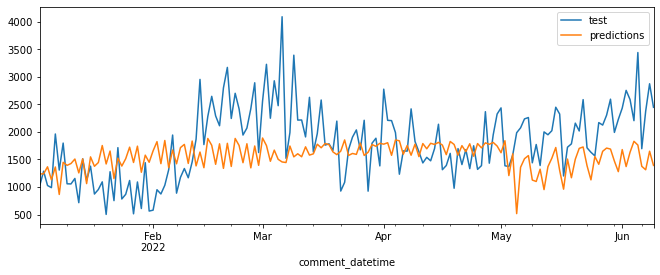

In [152]:
# Visualize the result between testing and prediction

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 4))
y_test.plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();